# Определение перспективного тарифа для телеком компании

### Описание проекта  
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Импорт данных и библиотек, предобработка данных

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
sms = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

#### Обработка таблиц: тарифы

In [3]:
tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Все данные и типы корректны. Исправляю названия столбцов: во-первых, здесь и далее заменяю messages на sms и minute на min для краткости, во-вторых - mg на mb (мегабайты):

In [5]:
tariffs.columns = [
    'sms_included',
    'mb_per_month_included',
    'mins_included',
    'rub_monthly_fee',
    'rub_per_gb',
    'rub_per_sms',
    'rub_per_min',
    'tariff_name'
]

In [6]:
tariffs

,sms_included,mb_per_month_included,mins_included,rub_monthly_fee,rub_per_gb,rub_per_sms,rub_per_min,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Обработка таблиц: звонки

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')

После исправления типа данных для даты все типы корректны. Пропусков нет.  
Для анализа по месяцам в этой и следующих таблицах сразу добавляю столбец с месяцем. Предварительно проверяю, что все месяцы относятся только к одному году.

In [10]:
calls.columns = ['id', 'date', 'duration', 'user_id']

In [11]:
calls['date'].dt.year.unique()

array([2018])

In [12]:
calls['month'] = calls['date'].dt.month

Судя по первым строкам, id звонка должен быть уникальным как минимум в рамках одной даты, поэтому в таблице не должно быть дубликатов. Среди звонков есть звонки с нулевой продолжительностью, это нормально, так как всегда есть неотвеченные или сброшенные вызовы. Так как такие звонки не тарифицируются, их можно удалить из датасета.

In [13]:
calls_length = len(calls)
calls = calls.drop_duplicates().reset_index(drop=True)
calls = calls[calls['duration'] > 0]
print('Удалено значений:', calls_length - len(calls))

Удалено значений: 39613


Для дальнейшего анализа можно округлить значения минут в большую сторону и изменить тип данных:

In [14]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int')

#### Обработка таблиц: сообщения

In [15]:
sms.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [17]:
sms.columns = ['id', 'date', 'user_id']

In [18]:
sms['date'] = pd.to_datetime(sms['date'], format='%Y.%m.%d')

In [19]:
sms['date'].dt.year.unique()

array([2018])

In [20]:
sms['month'] = sms['date'].dt.month

In [21]:
sms_length = len(sms)
sms = sms.drop_duplicates().reset_index(drop=True)
print('Удалено значений:', sms_length - len(sms))

Удалено значений: 0


После исправления типа данных для даты все типы корректны. Пропусков нет.

#### Обработка таблиц: интернет

In [22]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [24]:
internet.columns = ['id', 'mb_used', 'date', 'user_id']

In [25]:
internet['date'] = pd.to_datetime(internet['date'], format='%Y.%m.%d')

In [26]:
internet['date'].dt.year.unique()

array([2018])

In [27]:
internet['month'] = internet['date'].dt.month

In [28]:
internet_length = len(internet)
internet = internet.drop_duplicates().reset_index(drop=True)
#предполагаю, что нулевые сессии не тарифицируются, а отрициательные (если есть) - некорретны:
internet = internet[internet['mb_used'] > 0] 
print('Удалено значений:', internet_length - len(internet))

Удалено значений: 19598


Для дальнейшего анализа можно округлить значения мегабайт в большую сторону и изменить тип данных:

In [29]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int')

После исправления типа данных для даты все типы корректны. Пропусков нет.

#### Обработка таблиц: пользователи

In [30]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Привожу даты к соответствующему типу данных:

In [32]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')

Делаю базовые проверки данных:  
- наличие дубликатов в столбце user_id - единственном, где их не должно быть,
- дата регистрации должна быть после изобретения сотовой связи и до 2018 года включительно,
- дата прекращения - до даты регистрации,
- возраст - от 18 до 118 лет без артефактов,
- тарифы - из таблицы тарифов.

In [33]:
users[users.duplicated(['user_id'], keep=False)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [34]:
users['reg_date'].dt.year.value_counts().sort_values(ascending = False)

2018    500
Name: reg_date, dtype: int64

Text(0, 0.5, 'Количество абонентов')

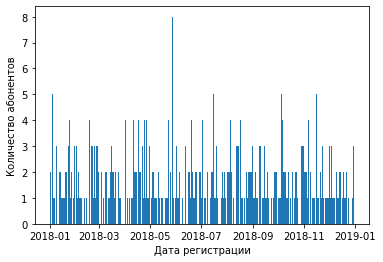

In [35]:
plt.hist(users['reg_date'], bins = 365)
plt.xlabel('Дата регистрации')
plt.ylabel('Количество абонентов')

Все пользователи подключили тариф в течение 2018 года, поэтому среди данных будет достаточно много неполных месяцев использования (аналогично с прекращением использования тарифа). Чтобы выделить их для дальнейшего анализа, добавляю столбцы с датой регистрации и датой прекращения тарифа. 

In [36]:
users['reg_month'] = users['reg_date'].dt.month
users['churn_month'] = users['reg_date'].dt.month

In [37]:
users.query('churn_date < reg_date')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month


Text(0, 0.5, 'Количество абонентов')

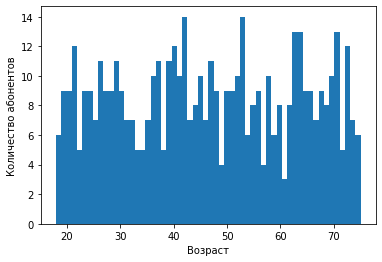

In [38]:
plt.hist(users['age'], bins = (users['age'].max() - users['age'].min()+1))
plt.xlabel('Возраст')
plt.ylabel('Количество абонентов')

In [39]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [40]:
users['city'].value_counts(ascending = False).head(10)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Казань              14
Омск                14
Уфа                 12
Набережные Челны    11
Екатеринбург        11
Краснодар           11
Ульяновск           11
Name: city, dtype: int64

Все данные корректны.

## Шаг 2. Подготовка данных

Создаю таблицу, группирующую по полям user_id и month:  
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам:

In [41]:
calls_volume = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])
sms_volume = sms.groupby(['user_id', 'month'])['id'].count()
internet_volume = internet.groupby(['user_id', 'month']).sum()['mb_used']
df = pd.concat([calls_volume, sms_volume, internet_volume], axis=1)
df = df.reset_index()

Теперь, когда данные агрегированы по мегабайтам, их можно еще раз округлить вверх до гигабайт. А пропущенные значения во всех столбцах - заменить нолями.

In [42]:
df = df.fillna(0)
df['mb_used'] = (df['mb_used'] / 1024).apply(np.ceil)
columns = ['user_id', 'month', 'calls', 'mins', 'sms', 'gbs']
df.columns = columns
for column in columns:
    df[column] = df[column].astype('int')
df.head()

,user_id,month,calls,mins,sms,gbs
0,1000,5,17,159,22,3
1,1000,6,28,172,60,23
2,1000,7,41,340,75,14
3,1000,8,42,408,81,14
4,1000,9,46,466,57,15


Месяцы, в которые пользователь начал или прекратил использование тарифа - неполные, в эти месяцы количество действий пользователя меньше. Они нужны для оценки полной выручки, но при сравнении тарифов между собой они создают искажения. Например, после запуска нового тарифа из-за большого количества новых пользователей с неполным месяцем использования тарифа средняя выручка с пользователя в месяц ниже фактической. В связи с этим, я исключаю неполные месяцы. Для этого я добавляю к таблице данные из таблицы пользователей (втч город и название тарифа для будущего анализа) и удаляю те строки, где месяц совпадает с месяцем начала или прекращения использования тарифа:

In [43]:
df = df.merge(users[['user_id', 'city', 'tariff','reg_month','churn_month']], on='user_id', how='left')

In [44]:
df_length = len(df)
df = df.query('reg_month != month and churn_month != month')
print('Удалено значений:', df_length - len(df))
del df['reg_month'], df['churn_month']

Удалено значений: 498


In [45]:
df.head()

,user_id,month,calls,mins,sms,gbs,city,tariff
1,1000,6,28,172,60,23,Краснодар,ultra
2,1000,7,41,340,75,14,Краснодар,ultra
3,1000,8,42,408,81,14,Краснодар,ultra
4,1000,9,46,466,57,15,Краснодар,ultra
5,1000,10,44,350,73,15,Краснодар,ultra


Считаю выручку.  
**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  
**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  
  
Прописываю функцию расчета выручки.

In [46]:
def revenue_calculator (row):
    if row['tariff'] == 'smart':
        mins = np.where(row['mins'] > 500, row['mins'] - 500, 0)
        sms = np.where(row['sms'] > 50, row['sms'] - 50, 0)
        gbs = np.where(row['gbs'] > 15, row['gbs'] - 15, 0)
        revenue = 550 + 3*mins + 3*sms + 200*gbs
    else:
        mins = np.where(row['mins'] > 3000, row['mins'] - 3000, 0)
        sms = np.where(row['sms'] > 1000, row['sms'] - 1000, 0)
        gbs = np.where(row['gbs'] > 30, row['gbs'] - 30, 0)
        revenue = 1950 + mins + sms + 150*gbs
    return revenue

In [47]:
df['revenue'] = df.apply(revenue_calculator, axis = 1)

Проверяю правильность расчетов:

In [48]:
print(df.query('tariff == "smart" and mins > 500 and sms > 50 and gbs > 15').head(1))
print('Расчетная выручка:',(550+56*3+40*3+5*200))
print(df.query('tariff == "ultra" and gbs > 30').head(1)) #пользователей с превышением и звонков, и интернета, и смс не нашлось
print('Расчетная выручка:',(1950+13*150))

     user_id  month  calls  mins  sms  gbs       city tariff  revenue
111     1015      7     67   556   90   20  Челябинск  smart     1838
Расчетная выручка: 1838
     user_id  month  calls  mins  sms  gbs             city tariff  revenue
159     1024     11    127  1146    0   43  Санкт-Петербург  ultra     3900
Расчетная выручка: 3900


## Шаг 3. Анализ данных
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Графики действий абонентов (звонки, смс, интернет) по каждому из двух тарифов в отдельности:


,mean,median,var,std,mean,median,var,std,mean,median,std
,mins,mins,mins,mins,sms,sms,sms,sms,gbs,gbs,gbs
tariff,,,,,,,,,,,
smart,450,452,31458,177,36,31,821,29,18,17,5
ultra,566,559,95544,309,52,42,2385,49,21,21,9


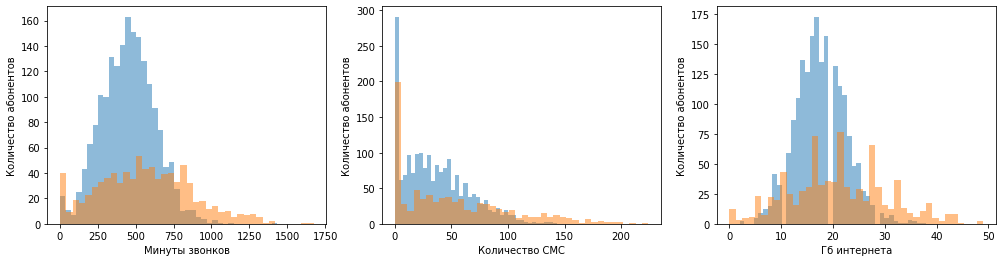

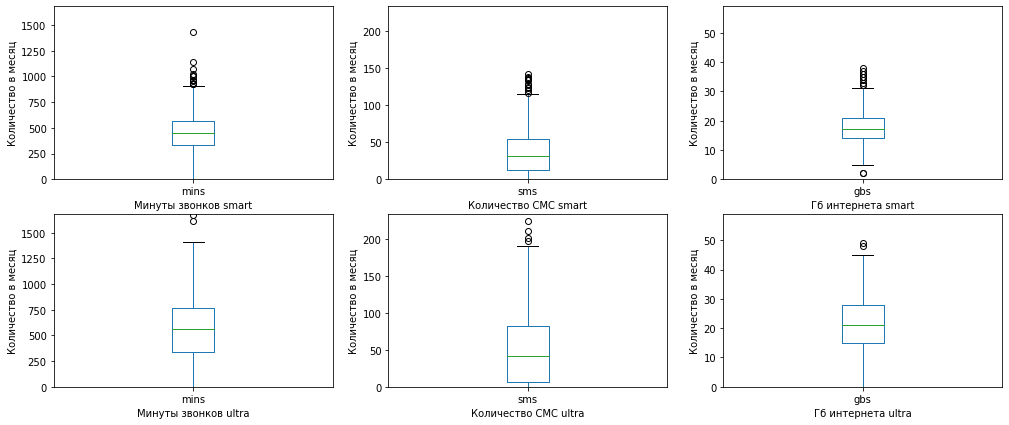

In [49]:
columns = ['mins', 'sms', 'gbs']
titles = ['Минуты звонков', 'Количество СМС', 'Гб интернета']
tariffs = ['smart', 'ultra']
bins = 40
fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize = (17,4))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (17,7))

print('Графики действий абонентов (звонки, смс, интернет) по каждому из двух тарифов в отдельности:')

for i in range(len(columns)):
    for j in range(len(tariffs)):
        (df[df['tariff'] == tariffs[j]][columns[i]]
         .plot(kind='box', ax=axes[j, i], ylim=(0,10+df[columns[i]].max()))
         .set(xlabel=titles[i]+' '+tariffs[j], ylabel="Количество в месяц"))
        (df[df['tariff'] == tariffs[j]][columns[i]]
         .plot(kind='hist', ax=axes2[i], bins = bins, alpha = 0.5)
         .set(xlabel=titles[i], ylabel="Количество абонентов"))
        
describe_mins = df.pivot_table(index='tariff', values ='mins', aggfunc=['mean', 'median', 'var', 'std']).round().astype('int')
describe_sms = df.pivot_table(index='tariff', values ='sms', aggfunc=['mean', 'median', 'var', 'std']).round().astype('int')
describe_gbs = df.pivot_table(index='tariff', values ='gbs', aggfunc=['mean', 'median', 'std']).round().astype('int')
describe = pd.concat([describe_mins, describe_sms, describe_gbs], axis=1)
describe

**Выводы:**  
- Большая часть пользователей (15%) не отправляет СМС, есть также те, кто не звонят (это могут быть сим-карты планшетов, модемов и социофобов), а пользователей без интернета почти нет. 

In [50]:
len(df[df['sms'] == 0]) / len(df)

0.15169366715758467

- На тарифе ultra дисперсия значений почти в 2 раза выше для всех трех показателей. Это связано с тем, тариф smart ограничен лимитами, сверх которых пользователи, вероятно, переходят на тариф ultra, а он, в свою очередь, никак не ограничен сверху.
- При этом, несмотря на более низкую дисперсию, на тарифе smart больше клиентов, чье количество действий выходит за пределы 1,5-квартильного размаха, что видно на диаграммах размаха. Это связано с тем, что количество действий на smart сконцентрировано вокруг значения, включенного в тариф, и мало пользователей выбиваются далеко за его пределы сверху. На ultra, наоборот, пределы настолько велики, что мало пользователей превышает количество, включенное в тариф. То есть ultra закрывает максимальные потребности практически всех клиентов.
- Как и можно было ожидать, пользователи тарифа ultra совершают больше действий (звонки, смс, объем использования интернета).  
- Среднее и медиана  незначительно отличаются для всех показателей и тарифов. Если судить по графикам, то для звонков и интернета распределение близко к нормальному. Для СМС большая доля нулевых значений, поэтому и среднее, и медиана отличаются больше, и без нулевых значений другие:

In [51]:
df[df['sms']!=0].pivot_table(index='tariff', values ='sms', aggfunc=['mean', 'median']).round().astype('int')

,mean,median
,sms,sms
tariff,,
smart,42,38
ultra,65,55


- Вообще, распределение звонков и интернета близко к нормальному, а СМС - к распределению Пуассона. Вероятность, что клиенту понадобится отправить еще одно СМС в том же месяце, меньше с каждым следующим сообщением, то есть потребность в СМС достаточно невелика и нестабильна.
- Для звонков и смс на тарифе smart медиана чуть ниже (на 10% и 38%) количества, включенного в тариф. На тарифе ultra лимиты в несколько (5 и 20) раз выше, а медиана отличается от тарифа smart не так сильно (19%-26%), потому что  максимальные значения в 2-5 раз ниже количества, включенного в тариф. 
- Для интернета ситуация отличается: медиана на тарифах - 18 и 21 Гб, и есть много пользователей, использующих больше включенного в тарифы трафика, вплоть до 50 Гб.
- Таким образом, интернет явно является основной потребностью абонентов, и главной причиной подключения более дорогого тарифа. Включенные в него звонки и смс не используются полностью ни одним абонентом.  
  
СМС всегда отправляются поштучно и их количество дискретно. Оценивать объем сессии интернета нет смысла, так как сессия технический параметр. А вот продолжительность звонков можно оценить:

Средняя продолжительность звонка, мин: 8.9


Text(0, 0.5, 'Количество звонков')

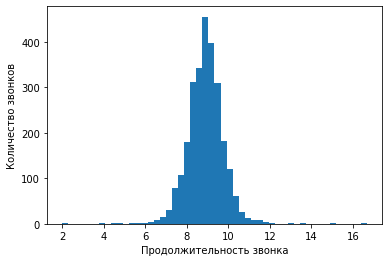

In [64]:
df['calls_length'] = np.where(df['calls'] != 0, df['mins'] / df['calls'], np.NaN) #чтобы избежать деления на ноль
print('Средняя продолжительность звонка, мин:', df['calls_length'].mean().round(1))
plt.hist(df[df['calls_length'].notnull()]['calls_length'], bins=50)
plt.xlabel('Продолжительность звонка')
plt.ylabel('Количество звонков')

Длине звонков в нормальных условиях должно соответствовать распределение Пуассона. Видимо, выборка совсем не случайна, однако недостаточно данных, чтобы понять причину этого.  
  
Так как СМС неинформативны, можно поискать графические связи между объемом использования интернета и звонков:

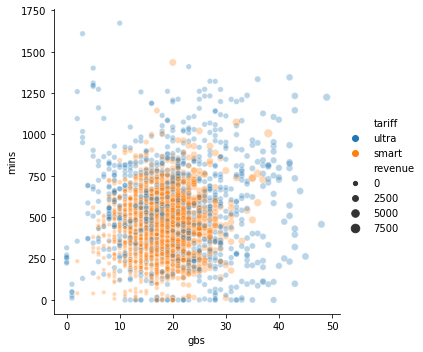

In [53]:
sns.relplot(x="gbs", y="mins", hue="tariff", size="revenue", data=df, alpha = 0.3)

На графике видно главное скопление потребностей в звонках и интернете, а также то, что при превышении и того, и другого абоненты переключаются на тариф ultra, что вполне ожидаемо.

## Шаг 4. Проверка гипотез  

In [54]:
alpha = 0.05
print('Уровень значимости:', alpha)

Уровень значимости: 0.05


Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» **не** различается  
**Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

In [55]:
revenue_test = st.ttest_ind(df[df['tariff'] == 'smart']['revenue'], df[df['tariff'] == 'ultra']['revenue'], equal_var = True)
print('p-значение: ', revenue_test.pvalue)
if (revenue_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.1619571956628993e-104
Отвергаем нулевую гипотезу


Нулевая гипотеза: средняя выручка пользователей из Москвы **не** отличается от выручки пользователей из других регионов  
**Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

In [56]:
revenue_test = st.ttest_ind(df[df['city'] == 'Москва']['revenue'], df[df['city'] != 'Москва']['revenue'], equal_var = True)
print('p-значение: ', revenue_test.pvalue)
if (revenue_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.49443029003369776
Не получилось отвергнуть нулевую гипотезу


Обе гипотезы не получилось подтвердить (т.е. не получилось отвергнуть противоположные).  
Можно также посмотреть на числовые и графические данные:

In [57]:
df['moscow'] = np.where(df['city'] == 'Москва', 'Москва', 'Не Москва')
df.pivot_table (index=['tariff', 'moscow'], values = 'revenue', aggfunc=['mean', 'median'])

mean  median
                      revenue revenue
tariff moscow                        
smart  Москва     1360.946708    1177
       Не Москва  1412.767949    1157
ultra  Москва     2093.782383    1950
       Не Москва  2089.751553    1950

[Text(0, 0.5, 'Количество абонентов'), Text(0.5, 0, 'Выручка в месяц')]

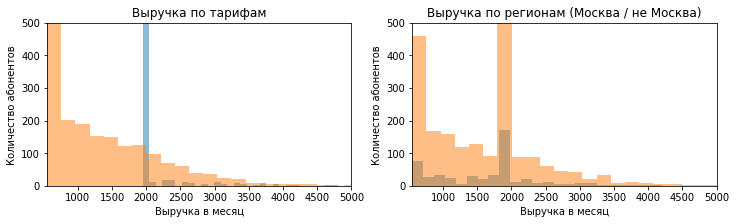

In [58]:
xlim = (550,5000)
ylim = (0,500)
bins = 30

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,3))

(df.query('tariff == "ultra"')['revenue']
 .plot(kind='hist', ax=axes[0], bins = bins, alpha = 0.5, xlim = xlim, ylim = ylim, title = 'Выручка по тарифам')
 .set(xlabel='Выручка в месяц', ylabel="Количество абонентов"))
(df.query('tariff == "smart"')['revenue']
 .plot(kind='hist', ax=axes[0], bins = bins, alpha = 0.5, xlim = xlim, ylim = ylim, title = 'Выручка по тарифам')
 .set(xlabel='Выручка в месяц', ylabel="Количество абонентов"))
(df.query('moscow == "Москва"')['revenue']
 .plot(kind='hist', ax=axes[1], bins = bins, alpha = 0.5, xlim = xlim, ylim = ylim, title = 'Выручка по регионам (Москва / не Москва)')
 .set(xlabel='Выручка в месяц', ylabel="Количество абонентов"))
(df.query('moscow == "Не Москва"')['revenue']
 .plot(kind='hist', ax=axes[1], bins = bins, alpha = 0.5, xlim = xlim, ylim = ylim, title = 'Выручка по регионам (Москва / не Москва)')
 .set(xlabel='Выручка в месяц', ylabel="Количество абонентов"))

Выводы:  
- и среднее, и медиана ожидаемо значительно различаются между тарифами. Причина этого видна на графике: у тарифа ultra есть пик на значении абонентской платы в 1950 рублей, что выше среднего тарифа smart.
- выручка между Москвой и регионами на графике выглядит распределенной похожим образом, за исключением того, что в регионах больше доля пользователей с минимальной (550 рублей) выручкой. Если посмотреть на таблицу, то видна разница: для тарифа ultra выручка между Москвой и регионами не отличается; для тарифа smart медиана выше в Москве, а среднее - в регионах. Скорее всего, это вызвано тем, что в регионах абоненты менее охотно переходят на тариф ultra, за счет этого средняя выручка smart чуть выше. Однако из-за большей доли абонентов с минимальной выручкой медиана ниже, чем в Москве. Можно проверить, что доля абонентов ultra в Москве выше:  

In [59]:
ultra_share_moscow = len(df.query('tariff == "ultra" and moscow == "Москва"')) / len(df.query('moscow == "Москва"'))
ultra_share_regions = len(df.query('tariff == "ultra" and moscow == "Не Москва"')) / len(df.query('moscow == "Не Москва"'))
print(ultra_share_moscow, ultra_share_regions)

0.376953125 0.29219600725952816


## Шаг 5. Общий вывод  
Основная часть выводов написана в разделах 3 или 4. Дополнительно можно отметить несколько моментов:  
буду считать ситуацию, при которой пользователь платит с текущим уровнем использования услуг оператора меньше, чем платил бы, используя другой тариф, рациональным выбором. Для расчета рациональности считаю выручку, исходя из неиспользуемого тарифа:

In [60]:
def rationality (row):
    if row['tariff'] == 'ultra':
        mins = np.where(row['mins'] > 500, row['mins'] - 500, 0)
        sms = np.where(row['sms'] > 50, row['sms'] - 50, 0)
        gbs = np.where(row['gbs'] > 15, row['gbs'] - 15, 0)
        revenue = 550 + 3*mins + 3*sms + 200*gbs
    else:
        mins = np.where(row['mins'] > 3000, row['mins'] - 3000, 0)
        sms = np.where(row['sms'] > 1000, row['sms'] - 1000, 0)
        gbs = np.where(row['gbs'] > 30, row['gbs'] - 30, 0)
        revenue = 1950 + mins + sms + 150*gbs
    return revenue
df['revenue2'] = df.apply(rationality, axis = 1)
df['rationality'] = (df['revenue2'] - df['revenue']) / (df['revenue'] + df['revenue2'])

Значение в столбце rationality ниже 0 говорит о том, что пользователь переплачивает за тариф, и наоборот. Разумеется, расчет относится к конкретному месяцу и не учитывает возможные колебания использования услуг и ограничения смены тарифов. Результаты уровней рациональности:

[Text(0, 0.5, 'Количество абонентов'), Text(0.5, 0, 'Уровень рациональности')]

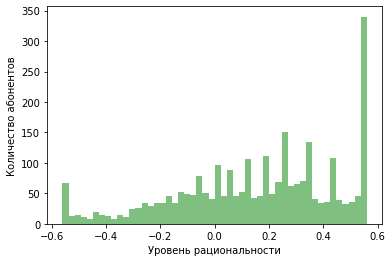

In [61]:
(df['rationality']
 .plot(kind='hist', bins = 50, alpha = 0.5, color = 'green')
 .set(xlabel='Уровень рациональности', ylabel="Количество абонентов"))

In [62]:
print('Доля пользователей, рационально выбирающих тариф:', len(df.query('rationality >= 0')) / len(df))
print('в том числе в Москве:', len(df.query('city == "Москва" and rationality >= 0')) / len(df.query('city == "Москва"')))
print('в том числе вне Москвы:', len(df.query('city != "Москва" and rationality >= 0')) / len(df.query('city != "Москва"')))

Доля пользователей, рационально выбирающих тариф: 0.7150220913107511
в том числе в Москве: 0.763671875
в том числе вне Москвы: 0.7037205081669692


Также считаю соотношение средней и суммарной выручки по тарифам: 

In [63]:
print(df[df['tariff'] == 'ultra']['revenue'].mean() / df[df['tariff'] == 'smart']['revenue'].mean() - 1)
print(df[df['tariff'] == 'smart']['revenue'].sum() / df[df['tariff'] == 'ultra']['revenue'].sum() - 1)

0.4891206438575191
0.5075490028001599


Выводы на основе расчетов:  
- выручка на одного абонента ultra выше smart в полтора раза (на 49%)  
- выручка smart в целом выше, чем ultra, также в полтора раза (51%) за счет большего количества пользователей
- доля пользователей тарифа ultra в Москве выше, чем вне Москвы 
- как показала проверка, пользователи в 72% случаев выбирают тариф рационально  
  
Исходя из этих расчетов, можно сделать вывод относительно цели исследования: определить распределение рекламного бюджета. Клиенты рациональны и, вероятно, не выберут более дорогой тариф только из-за рекламы. Соответственно, при возможности таргетированной рекламы нужно выделять аудиторию, которая потенциально может использовать больший объем звонков, смс и интернета, и продвигать для нее тариф ultra, так как соотношение затрат на привлечение клиента к выручке с клиента будет выше для тарифа ultra. Если рассматривается нетаргетированная реклама, нужно продвигать тариф smart, который и более популярен, и приносит больше выручки, так как это привлечет больше клиентов в абсолютных значениях.  
В основном пользователи превышали объемы действий, включенных в тариф, по интернету и в меньшей степени по звонкам, также почти не было пользователей, которые не использовали бы интернет, в отличие от звонков и смс. Поэтому реклама должна акцентироваться  на мобильном интернете.